<a href="https://colab.research.google.com/github/VictorZwart/ScriptieOffensiveLanguage/blob/main/scriptie_code_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN Convolutional Neural Networks

Based on the following tutorial: https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9

In [ ]:
# get gpu specs
!nvidia-smi
# Tesla K80 (11441MiB) = bad
# Tesla T4  (15109MiB) = good

Tue May  4 12:54:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

First import all the necessary packages

In [ ]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# Modules for data manipulation
import numpy as np
import pandas as pd
import re
import csv

import urllib
import shutil
import sys
from sklearn.model_selection import train_test_split

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

from keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download the Coosto model 

In [ ]:
# upload data
from google.colab import files
uploaded = files.upload()


Saving batch_2_train_victor.csv to batch_2_train_victor.csv


In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

Import Data

In [ ]:
# Function to get the data with the goal, being either 'target' or 'explicitness'
def get_data(goal):
    full_data = []
    with open('batch_2_train_victor.csv', encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')
        for index, line in enumerate(reader):

                full_data.append([line['text'], line[goal]])

    df_full = pd.DataFrame(full_data)
    df_full.columns = ["text", goal]
    train, test = train_test_split(df_full, test_size=0.2,
                                shuffle=True,
                                    random_state=42)
    return train, test
train_exp, test_exp = get_data("explicitness")
train_target, test_target = get_data("target")
print(train_target)


                                                   text target
4675  @Pelpindaa Er zijn vrijwel geen corona gevalle...   None
1204  Ik wacht nog steeds hoopvol op die ene maandag...   None
5640  Ehm, Sybren, newsflash. Er is helemaal niks Ou...   None
4638  Dag 6 - Zwart-Wit Plaats ook tien dagen lang z...   None
5562  @Michel1401 @BrazziBroglio Dit verbloemen ze d...   None
...                                                 ...    ...
3772  @jos1963 @FreetrueC @pufpufpafpaf Politie voer...   None
5191  @hassnaaxx Ze zijn minste met islam bezig alle...   None
5226  @GrootKo Er is daar al een dame als partijleid...   None
5390  @POL_Vrederust @maestraroos Ik zag dit en beki...   None
860   @Gerbijl @jcgmruiter inderdaad , dit toont de ...   None

[4812 rows x 2 columns]


Visualisation of the data

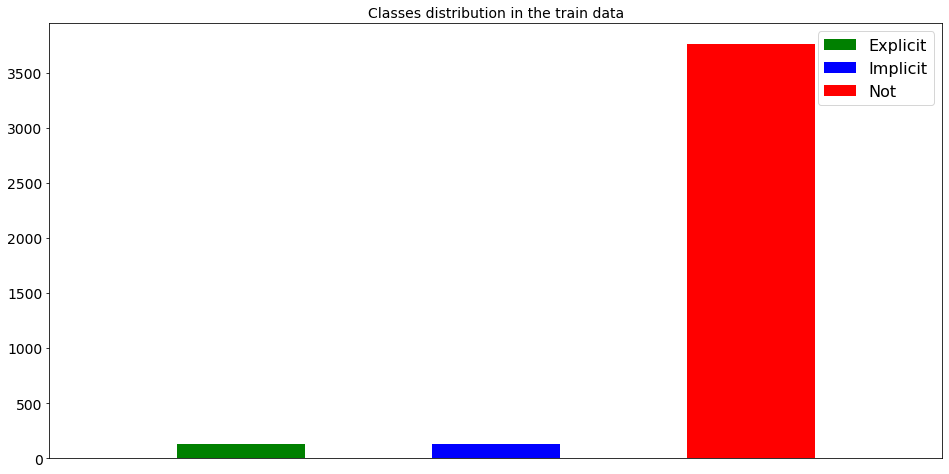

In [ ]:
#plot of explicitness
plt.hist(train_exp[train_exp.explicitness == "EXPLICIT"].explicitness,
         bins=2, color='green', label='Explicit')
plt.hist(train_exp[train_exp.explicitness == "IMPLICIT"].explicitness,
         bins=2, color='blue', label='Implicit')
plt.hist(train_exp[train_exp.explicitness == "NOT"].explicitness,
         bins=2, color='red', label='Not')
plt.title('Classes distribution in the train data')
plt.xticks([])
plt.xlim(-0.5, 3)
plt.legend()
plt.show()

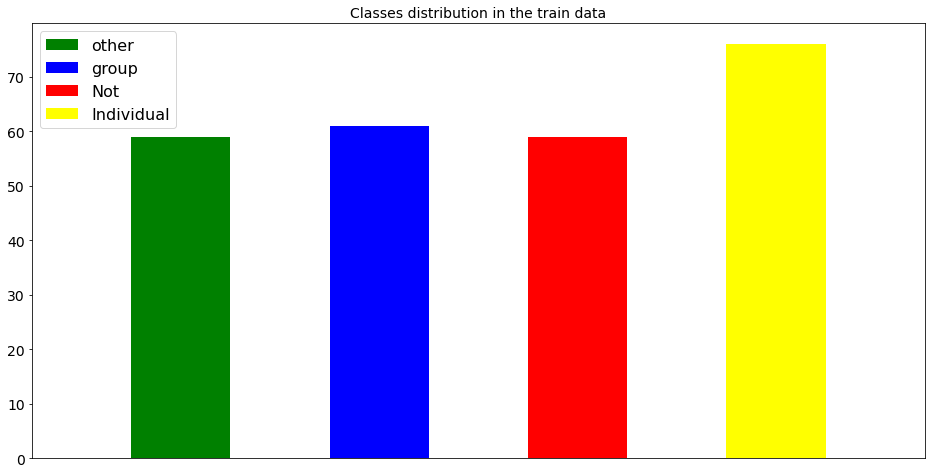

In [ ]:
#plot of target
plt.hist(train_target[train_target.target == "OTHER"].target,
         bins=2, color='green', label='other')
plt.hist(train_target[train_target.target == "GROUP"].target,
         bins=2, color='blue', label='group')
plt.hist(train_target[train_target.target == "NOT"].target,
         bins=2, color='red', label='Not')
plt.hist(train_target[train_target.target == "INDIVIDUAL"].target,
         bins=2, color='yellow', label='Individual')
plt.title('Classes distribution in the train data')
plt.xticks([])
plt.xlim(-0.5, 4)
plt.legend()
plt.show()

In [ ]:
all_reviews = np.array([], dtype=str)
all_reviews = np.concatenate((all_reviews, df_full["text"]), axis=0)
print('Total number of reviews:', len(all_reviews))
print(all_reviews)

Total number of reviews: 6016
['@JoostNiemoller Het wordt de hoogste tijd dat we weer laten zien wie er de baas is.'
 'Turken en Marokkanen kunnen niet op u stemmen, mijnheer @HeroBrinkman? Dat is buitenland. Of bedoelt u gewoon Nederlandse ondernemers?'
 '@Hello_Nighthawk Alles Trump is verantwoordelijk voor aanpak Corona dat hij niet serieus nam. https://t.co/3bJR8UGyXY'
 ...
 '@RadboudStudents een unieke kans om kennis te maken met wat daar voor door moet gaan. Hoe wil u er anders duidelijkheid over krijgen? U las zojuist “wat daar voor door moet gaan” omdat de “humanisten” en hun sekte, het Humanistisch Verbond, volstrekt niet humanistisch zijn. Een'
 '@RadboudStudents humanist dient tenminste te vechten voor lotsverbetering van de armen, van mensen aan de onderkant van de samenleving. Dit doen ze niet, mogelijk omdat Van Praag de sociale kant van het humanisme maar wegliet. Dit is onzinnig. Humanisme draait immers om'
 '@RadboudStudents geaardheid die humanisten tientallen jaren a

In [ ]:
# Word embeddings:

def demoModel(inputFile):
    # Let's not presume gensim installation until needed
    import gensim
    sys.stderr.write("Loading model...\n")
    model = gensim.models.KeyedVectors.load_word2vec_format(inputFile, binary=True)
    sys.stderr.write("Model loaded\n")

    return model

def downloadModel():
    modelUrl = "https://github.com/coosto/dutch-word-embeddings/releases/download/v1.0/model.bin"


    # Request model data
    try:
        request = urllib.request.Request(modelUrl)
        with urllib.request.urlopen(request) as response, open("/content/drive/MyDrive/Scriptie/code/Coosto", 'wb') as fp:
            shutil.copyfileobj(response, fp)
            sys.stderr.write("Model saved: {}\n".format(fp.name))
        return "/content/drive/MyDrive/Scriptie/code/Coosto"
    except urllib.error.HTTPError as error:
        sys.stderr.write("Error fetching model from github.com - {}\n".format(error))
        sys.stderr.write("{}".format(error.read()))
        exit(1)



In [ ]:
model = downloadModel()

Model saved: /content/drive/MyDrive/Scriptie/code/Coosto


In [ ]:
coosto_model = demoModel(model)
coosto_model.most_similar("pilsje")

Loading model...
Model loaded


[('biertje', 0.9145998954772949),
 ('glas_bier', 0.7679998874664307),
 ('wijntje', 0.7564073801040649),
 ('paar_biertjes', 0.7425606846809387),
 ('pilsjes', 0.7367861270904541),
 ('biertjes', 0.7344973087310791),
 ('colaatje', 0.7323644161224365),
 ('pilske', 0.724961519241333),
 ('borreltje', 0.7243227958679199),
 ('pils', 0.7234804630279541)]

In [ ]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

input_length = coosto_model.vector_size # define the input length
print('Convert sentences to sentences with ngrams...', end='\r')
print('Convert sentences to sentences with ngrams... (done)')
X_pad = pad_sequences(
    sequences=vectorize_data(all_reviews, vocab=coosto_model.wv.vocab),
    maxlen=input_length,
    padding='post')

print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [ ]:
print(X_pad.shape)

(6016, 300)


In [ ]:
Y_train_data = df_full["explicitness"].factorize()[0]

X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.2,
    shuffle=True,
    random_state=69)

In [ ]:
def build_model(embedding_matrix, input_length):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [ ]:
cnn_model = build_model(
    embedding_matrix=coosto_model.wv.vectors,
    input_length=input_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          75143700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               1200250   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 76,373,033
Trainable params: 1,229,333
Non-trainable params: 75,143,700
__________________________________

In [ ]:
cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
cnn_model.summary()

# Fitting the data onto model
cnn_model.fit(
    x=X_train, 
    y= y_train, 
    validation_data=(X_test, y_test), 
    batch_size=100,
    epochs=5, 
    verbose=2)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          75143700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               1200250   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 76,373,033
Trainable params: 1,229,333
Non-trainable params: 75,143,700
__________________________________

In [ ]:
# Getting score metrics from our model
scores = cnn_model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 78.41%


Meer visualisatie

In [ ]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [ ]:
y_train_pred = cnn_model.predict_classes(X_train)
y_test_pred = cnn_model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


NameError: ignored

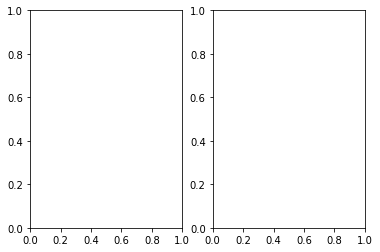

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])

{'loss': [0.33290478587150574, 0.3279065191745758, 0.32427510619163513, 0.3219793140888214, 0.31652840971946716], 'accuracy': [0.9355546832084656, 0.9353551268577576, 0.9351556301116943, 0.9351556301116943, 0.9353551268577576], 'val_loss': [0.30251938104629517, 0.3058440387248993, 0.3024248480796814, 0.30297085642814636, 0.3065956234931946], 'val_accuracy': [0.9425837397575378, 0.9425837397575378, 0.9425837397575378, 0.9425837397575378, 0.9425837397575378]}


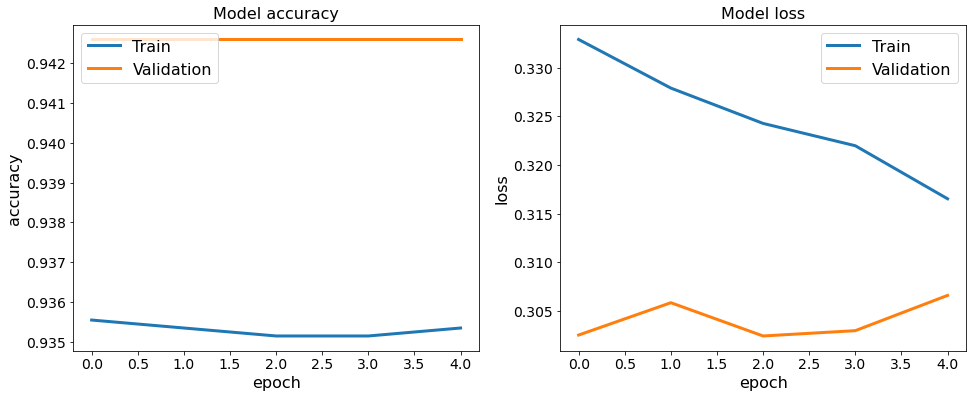

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
print(history.history)
# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()